# Train and Deploy Model on Truefoundry
This notebook demonstrates a demo on how you can train an image classification model on mnist dataset and deploy the model as a Gradio App on truefoundry platform.

# 🛠 Setup
To follow along with the notebook, you will have to do the following:
* Install **servicefoundry**
* Setup logging
* Select the Workspace in which you want to deploy your application.
* Install the required packages

In [ ]:
!pip install -U "servicefoundry"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import logging
[logging.root.removeHandler(h) for h in logging.root.handlers]
logging.basicConfig(level=logging.INFO, format='%(asctime)s [%(name)s] %(levelname)-8s %(message)s')

In [ ]:
import os
os.environ["TFY_HOST"]="https://app.devtest.truefoundry.tech"

In [ ]:
!sfy login --relogin

Opening:- https://app.devtest.truefoundry.tech/authorize/device?userCode=465M5H
Please click on the above link if it is not automatically opened in a browser window.
/usr/bin/xdg-open: 869: www-browser: not found
/usr/bin/xdg-open: 869: links2: not found
/usr/bin/xdg-open: 869: elinks: not found
/usr/bin/xdg-open: 869: links: not found
/usr/bin/xdg-open: 869: lynx: not found
/usr/bin/xdg-open: 869: w3m: not found
xdg-open: no method available for opening 'https://app.devtest.truefoundry.tech/authorize/device?userCode=465M5H'
Successfully logged in to 'https://app.devtest.truefoundry.tech' as 'aditya-j' (aditya@truefoundry.com)


In [ ]:
print("https://app.devtest.truefoundry.tech/workspaces")

https://app.devtest.truefoundry.tech/workspaces


### Workspace FQN
Once you run the cell below you will get a prompt to enter your workspace. <br>
* Step 1: Click on the link given in the prompt.
* Step 2: Identify the Workspace you want to deploy the application in.
* Step 3: Copy the Workspace FQN <br>
![Copying Workspace FQN](https://files.readme.io/730fee2-Screenshot_2023-02-28_at_2.08.34_PM.png)
* Step 4: Paste the  Workspace FQN in the prompt and press enter.

In [ ]:
WORKSPACE = "<Your Workspace FQN>"

# MNIST Dataset - Problem Statement and Data Exploration

The MNIST dataset is a popular benchmark dataset in the field of machine learning and computer vision. It consists of a large collection of handwritten digits (0-9) in grayscale images, along with their corresponding labels.

### Problem Statement

The problem associated with the MNIST dataset is to train a model that can accurately classify the given images of handwritten digits into their respective classes. It is a classification problem with 10 classes (0-9), where each image represents a single digit.

### Data Exploration

Let's explore the MNIST dataset by loading and visualizing some of its samples.

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist

# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

print(f"The number of train images: {len(x_train)}")
print(f"The number of test images: {len(x_test)}")

11490434/11490434 [==============================] - 0s 0us/step
The number of train images: 60000
The number of test images: 10000


The MNIST dataset is divided into two sets: a training set (x_train and y_train) and a testing set (x_test and y_test). The training set contains 60,000 images, while the testing set contains 10,000 images.

Now, let's visualize some samples from the dataset using matplotlib:

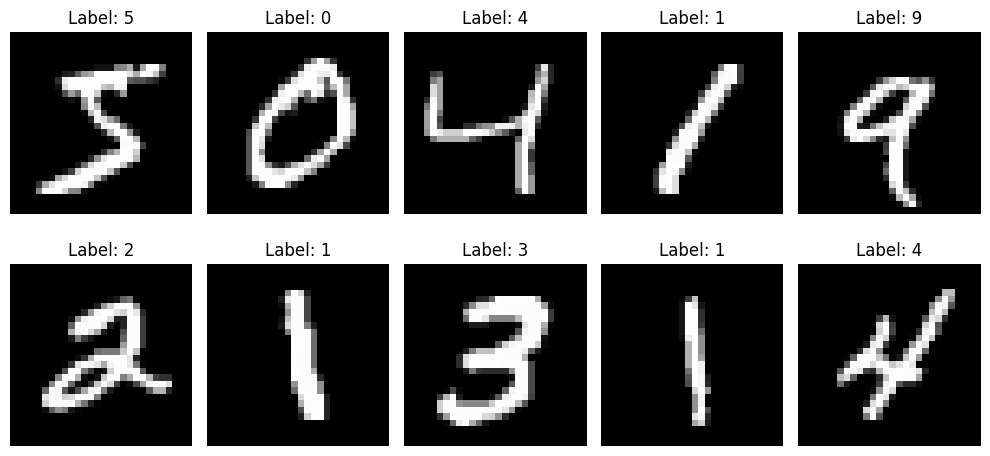

In [ ]:
# Plot some sample images
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(x_train[i], cmap='gray')
    plt.title(f"Label: {y_train[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()


The code above plots a grid of 10 sample images from the training set. Each image is displayed in grayscale, and the corresponding label is shown as the title.

You can see that the images are 28x28 pixels in size and represent handwritten digits. The labels indicate the true values of the digits.

# Train the model

First we will install the required libraries for training.<br>
Now we are going to train our model


In [ ]:
!pip install tensorflow
!pip install scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist

# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize the pixel values between 0 and 1
x_train = x_train / 255.0
x_test = x_test / 255.0

# Define the model architecture
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
epochs = 5
model.fit(x_train, y_train, epochs=epochs, validation_data=(x_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(x_test, y_test)
print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy}')

# Save the trained model
model.save('mnist_model.h5')

# Load the saved model
loaded_model = tf.keras.models.load_model('mnist_model.h5')

# Make predictions using the loaded model
predictions = loaded_model.predict(x_test[:10])
predicted_labels = [tf.argmax(prediction).numpy() for prediction in predictions]
print(f'Predicted labels: {predicted_labels}')

Epoch 1/5
1875/1875 [==============================] - 17s 9ms/step - loss: 0.2617 - accuracy: 0.9256 - val_loss: 0.1418 - val_accuracy: 0.9565
Epoch 2/5
1875/1875 [==============================] - 10s 6ms/step - loss: 0.1175 - accuracy: 0.9652 - val_loss: 0.1012 - val_accuracy: 0.9710
Epoch 3/5
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0811 - accuracy: 0.9759 - val_loss: 0.0856 - val_accuracy: 0.9743
Epoch 4/5
1875/1875 [==============================] - 10s 6ms/step - loss: 0.0603 - accuracy: 0.9818 - val_loss: 0.0844 - val_accuracy: 0.9749
Epoch 5/5
313/313 [==============================] - 1s 3ms/step - loss: 0.0766 - accuracy: 0.9768
Test loss: 0.07660061866044998
Test accuracy: 0.9768000245094299
1/1 [==============================] - 0s 100ms/step
Predicted labels: [7, 2, 1, 0, 4, 1, 4, 9, 5, 9]


# Deploy the model

### Creating the App Directory

The first step is to create a directory called "app" using the `mkdir` command and navigate into it using `%cd`

In [ ]:
!mkdir app
%cd app

mkdir: cannot create directory ‘app’: File exists
/content/app


### Preparing the Images
Now, we load the MNIST dataset and select images with labels 0 and 1 to create sample images for testing our Gradio interface:

In [ ]:
import numpy as np
from PIL import Image
# Load MNIST dataset
(_, _), (x_test, y_test) = mnist.load_data()

# Find the indices of images with label 0 and 1
zero_indices = np.where(y_test == 0)[0]
one_indices = np.where(y_test == 1)[0]

# Convert the images to PIL format and save as 0.jpg and 1.jpg
Image.fromarray(x_test[zero_indices[0]]).save("0.jpg")
Image.fromarray(x_test[one_indices[0]]).save("1.jpg")

### Creating the Requirements File
Then, we create a file called requirements.txt and write the required Python packages:

In [ ]:
%%writefile requirements.txt
tensorflow
gradio

Overwriting requirements.txt


The requirements.txt file specifies the dependencies for our project, which in this case are TensorFlow and Gradio.

### Creating the Main Script
In this cell, we create a file called main.py and write the code for the main script that will be executed by the Gradio server:

In [ ]:
%%writefile main.py
import gradio as gr
import tensorflow as tf
import numpy as np
from PIL import Image

def predict(img_arr):
  # Preprocess the image before passing it to the model
  img_arr = tf.expand_dims(img_arr, 0)
  img_arr = img_arr[:, :, :, 0]  # Keep only the first channel (grayscale)

  # Load the trained model
  loaded_model = tf.keras.models.load_model('mnist_model.h5')

  # Make predictions
  predictions = loaded_model.predict(img_arr)
  predicted_label = tf.argmax(predictions[0]).numpy()

  return str(predicted_label)

gr.Interface(fn=predict,
             inputs="image",
             outputs="label",
             examples=[["0.jpg"], ["1.jpg"]]
).launch(server_name="0.0.0.0", server_port=8080)

Overwriting main.py


This script defines a function predict that takes an image array as input, preprocesses it, loads a trained model from a file named "mnist_model.h5", and makes predictions on the image. The Gradio interface is then created using this function, specifying that the input is an image and the output is a label. The examples parameter provides the sample images we saved earlier.

###  Deploying the Service
Finally, we will define and deploy the Gradio service using the ServiceFoundry library:

In the code we define the service using the Service class. It encapsulates the configuration details of the service, such as its name, image build specifications, ports, and resource requirements.

* **name:** Specifies the name of the service, which in this case is set as "gradio".
* **image:** Defines the build specifications for the Docker image used by the service. Here, we use the PythonBuild class to specify that the image should be built using Python. The command parameter sets the command to execute when running the container, which is python main.py. The requirements_path parameter specifies the path to the requirements.txt file containing the required Python packages.
* **ports:** Specifies the ports to be exposed by the service. In this case, we expose port 8080. The host parameter sets the hostname or IP address to bind the port to. Please note that the provided host in the example is specific to the deployment environment.
* **resources:** Defines the resource requirements for the service, including memory limits, memory requests, ephemeral storage limits, ephemeral storage requests, CPU limits, and CPU requests. These parameters ensure that the service is allocated the necessary resources for proper execution.

In [ ]:
import argparse
import logging
from servicefoundry import Build, PythonBuild, Service, Resources, Port

logging.basicConfig(level=logging.INFO)

service = Service(
    name="gradio",
    image=Build(
        build_spec=PythonBuild(
            command="python main.py",
            requirements_path="requirements.txt",
        )
    ),
    ports=[
        Port(
            port=8080,
            host="<Your configured host>"
        )
    ],
    resources=Resources(memory_limit=500, memory_request=500, ephemeral_storage_limit=600, ephemeral_storage_request=600, cpu_limit=0.3, cpu_request=0.3),
)
service.deploy(workspace_fqn=WORKSPACE)

2023-06-22 23:27:02,198 [servicefoundry] WARNING  Did not find Docker locally installed on this system, image will be built remotely. For faster builds it is recommended to install Docker locally. If you always want to build remotely, please set `image.build_source.local_build` to `false` in your YAML spec or equivalently set `image=Build(build_source=LocalSource(local_build=False, ...))` in your `Service` or `Job` definition code.
2023-06-22 23:27:02,204 [servicefoundry] INFO     Uploading code for service 'gradio'
2023-06-22 23:27:02,208 [servicefoundry] INFO     Archiving contents of dir: '/content/app'
2023-06-22 23:27:02,215 [servicefoundry] INFO     Neither `.tfyignore` file found in /content/app nor a valid git repository found. We recommend you to create .tfyignore file and add file patterns to ignore
Packaging source code: 1it [00:00,  7.69it/s]
2023-06-22 23:27:02,359 [servicefoundry] INFO     Code archive size: '1.04 MiB'
Uploading package: 100%|██████████| 1.04M/1.04M [00:0

Output()

2023-06-22 23:27:04,304 [servicefoundry] INFO     State: 'INITIALIZED'
2023-06-22 23:27:14,524 [servicefoundry] INFO     State: 'BUILDING'
2023-06-22 23:27:14,707 [servicefoundry] INFO     Tailing build logs for 'gradio'


Waiting for the task to start...

[2023-06-22T23:27:19.485546+00:00] [Start] Downloading source code from remote source

[2023-06-22T23:27:19.776496+00:00] [Done] Download code completed

[2023-06-22T23:27:19.876846+00:00] [Start] Building and pushing the docker container. Please find the logs below

[2023-06-22T23:27:19.876862+00:00] [==== Docker logs start ====]

[2023-06-22T23:27:21.678412+00:00] [build] Servicefoundry version: 0.9.6

[2023-06-22T23:27:21.680208+00:00] [06/22/23 23:27:21] INFO     Dockerfile content:-

[2023-06-22T23:27:21.682131+00:00] INFO

[2023-06-22T23:27:21.682141+00:00] FROM --platform=linux/amd64 python:3.9

[2023-06-22T23:27:21.682145+00:00] ENV PATH=/virtualenvs/venv/bin:$PATH

[2023-06-22T23:27:21.682148+00:00] RUN python -m venv /virtualenvs/venv/

[2023-06-22T23:27:21.682150+00:00]

[2023-06-22T23:27:21.682155+00:00] COPY requirements.txt /tmp/requirements.txt

[2023-06-22T23:27:21.682157+00:00]

[2023-06-22T23:27:21.682161+00:00] && python -m pip install --use-pep517

[2023-06-22T23:27:21.682163+00:00] --no-cache-dir -r /tmp/requirements.txt

[2023-06-22T23:27:21.682165+00:00]

[2023-06-22T23:27:21.682168+00:00] COPY . /app

[2023-06-22T23:27:21.682172+00:00] ENTRYPOINT python main.py

[2023-06-22T23:27:21.682174+00:00]

[2023-06-22T23:27:21.682170+00:00] WORKDIR /app

[2023-06-22T23:27:21.682922+00:00] INFO     Starting docker build...

[2023-06-22T23:27:22.808694+00:00] #1 DONE 0.3s

[2023-06-22T23:27:22.808709+00:00]

[2023-06-22T23:27:22.808714+00:00] #2 [depot] connecting to amd64 builder

[2023-06-22T23:27:22.357358+00:00] #1 [depot] launching amd64 builder

[2023-06-22T23:27:23.359904+00:00]

[2023-06-22T23:27:23.359922+00:00] #3 [internal] load build definition from Dockerfile

[2023-06-22T23:27:23.359926+00:00] #3 transferring dockerfile:

[2023-06-22T23:27:23.605198+00:00]

[2023-06-22T23:27:23.109221+00:00] #2 DONE 0.3s

[2023-06-22T23:27:23.605138+00:00] #3 transferring dockerfile: 381B 0.2s done

[2023-06-22T23:27:23.605190+00:00] #3 DONE 0.3s

[2023-06-22T23:27:23.605206+00:00] #4 [internal] load .dockerignore

[2023-06-22T23:27:23.755269+00:00]

[2023-06-22T23:27:23.605218+00:00] #4 DONE 0.2s

[2023-06-22T23:27:23.755440+00:00] #5 [internal] load metadata for docker.io/library/python:3.9

[2023-06-22T23:27:23.906346+00:00] #5 ...

[2023-06-22T23:27:23.906414+00:00]

[2023-06-22T23:27:23.906420+00:00] #6 [auth] library/python:pull token for registry-1.docker.io

[2023-06-22T23:27:23.906423+00:00] #6 DONE 0.0s

[2023-06-22T23:27:24.057285+00:00]

[2023-06-22T23:27:24.057386+00:00] #5 [internal] load metadata for docker.io/library/python:3.9

[2023-06-22T23:27:24.205446+00:00] #5 DONE 0.6s

[2023-06-22T23:27:24.344900+00:00]

[2023-06-22T23:27:24.344979+00:00] #7 [1/6] FROM 
docker.io/library/python:3.9@sha256:98f018a1afd67f2e17a4abd5bfe09b998734ba7c1ee54780e7ed216f8b8095c3

[2023-06-22T23:27:24.345106+00:00] #7 DONE 0.0s

[2023-06-22T23:27:24.345161+00:00]

[2023-06-22T23:27:24.345045+00:00] #7 resolve 
docker.io/library/python:3.9@sha256:98f018a1afd67f2e17a4abd5bfe09b998734ba7c1ee54780e7ed216f8b8095c3 0.0s done

[2023-06-22T23:27:24.345209+00:00] #8 [internal] load build context

[2023-06-22T23:27:25.198787+00:00] #8 transferring context: 1.25MB 0.8s done

[2023-06-22T23:27:25.198842+00:00] #8 DONE 0.9s

[2023-06-22T23:27:25.349019+00:00]

[2023-06-22T23:27:25.349042+00:00] #9 [2/6] RUN python -m venv /virtualenvs/venv/

[2023-06-22T23:27:25.349135+00:00] #9 CACHED

[2023-06-22T23:27:25.349139+00:00]

[2023-06-22T23:27:25.349143+00:00] #10 [3/6] COPY requirements.txt /tmp/requirements.txt

[2023-06-22T23:27:25.349145+00:00] #10 CACHED

[2023-06-22T23:27:25.349148+00:00]

[2023-06-22T23:27:25.349151+00:00] #11 [4/6] RUN python -m pip install -U pip setuptools wheel && python -m pip 
install --use-pep517 --no-cache-dir -r /tmp/requirements.txt

[2023-06-22T23:27:25.349155+00:00] #11 CACHED

[2023-06-22T23:27:25.349156+00:00]

[2023-06-22T23:27:25.349158+00:00] #12 [5/6] COPY . /app

[2023-06-22T23:27:25.349159+00:00] #12 CACHED

[2023-06-22T23:27:25.349161+00:00] #13 [6/6] WORKDIR /app

[2023-06-22T23:27:25.349162+00:00] #13 CACHED

[2023-06-22T23:27:25.349163+00:00]

[2023-06-22T23:27:25.349164+00:00] #14 [auth] sharing credentials for 526077812922.dkr.ecr.eu-west-1.amazonaws.com

[2023-06-22T23:27:25.349165+00:00] #14 DONE 0.0s

[2023-06-22T23:27:25.349166+00:00]

[2023-06-22T23:27:25.349168+00:00] #15 exporting to image

[2023-06-22T23:27:25.349169+00:00] #15 exporting layers done

[2023-06-22T23:27:25.349171+00:00] #15 exporting manifest 
sha256:833c97c8139db116a4b66374f76311c62023ceb76647d92c26800cb53b73904f done

[2023-06-22T23:27:25.349174+00:00] #15 exporting manifest list 
sha256:16776a6596d51429ad1997463309edd554150d07d4a623f1e261c2dfa598eb8c done

[2023-06-22T23:27:25.349173+00:00] #15 exporting attestation manifest 
sha256:f741f24f8332327ff8fdfbf0f19a3bffaee09f512d46776626af17a378de7429 0.0s done

[2023-06-22T23:27:27.609443+00:00] #15 pushing layers for 
526077812922.dkr.ecr.eu-west-1.amazonaws.com/abhi-gcp-ws-gradio-35gvc:11@sha256:16776a6596d51429ad1997463309edd5541
50d07d4a623f1e261c2dfa598eb8c 2.3s done

[2023-06-22T23:27:27.609479+00:00] #15 pushing manifest for 
526077812922.dkr.ecr.eu-west-1.amazonaws.com/abhi-gcp-ws-gradio-35gvc:11@sha256:16776a6596d51429ad1997463309edd5541
50d07d4a623f1e261c2dfa598eb8c

[2023-06-22T23:27:25.349172+00:00] #15 exporting config 
sha256:93f03568b8abc936337f76efdef61fa4fdd409a2f6d73d16b111fca1e1b70e46 done

[2023-06-22T23:27:25.349176+00:00] #15 pushing layers for 
526077812922.dkr.ecr.eu-west-1.amazonaws.com/abhi-gcp-ws-gradio-35gvc:11@sha256:16776a6596d51429ad1997463309edd5541
50d07d4a623f1e261c2dfa598eb8c

[2023-06-22T23:27:28.459121+00:00] #15 DONE 3.1s

[2023-06-22T23:27:28.320187+00:00] #15 pushing manifest for 
526077812922.dkr.ecr.eu-west-1.amazonaws.com/abhi-gcp-ws-gradio-35gvc:11@sha256:16776a6596d51429ad1997463309edd5541
50d07d4a623f1e261c2dfa598eb8c 0.8s done

[2023-06-22T23:27:28.777706+00:00]

[2023-06-22T23:27:28.777736+00:00] Build Summary: 
https://depot.dev/orgs/4007kz3jhw/projects/2j4wshdq2v/builds/543vwcrbhz

[2023-06-22T23:27:28.982175+00:00] [==== Docker logs end ====]

[2023-06-22T23:27:28.982237+00:00] [Done] Docker image built and pushed

[2023-06-22T23:27:45.179984+00:00] [Start] Sending request to url: 
https://app.devtest.truefoundry.tech/api/svc/v1/x/builds/clj7rw9x70alv1hgubun2c5g3 with json {"status": 
"SUCCEEDED", "imageUri": "526077812922.dkr.ecr.eu-west-1.amazonaws.com/abhi-gcp-ws-gradio-35gvc:11"}

[2023-06-22T23:27:45.514213+00:00] [Done] Kubernetes deployment triggered. It may take 5-10s for the application to
be live.

[2023-06-22T23:27:45.514195+00:00] [Done] Image Built Successfully

2023-06-22 23:28:00,155 [servicefoundry] INFO     State: 'WAITING'
2023-06-22 23:28:05,271 [servicefoundry] INFO     State: 'DEPLOY_SUCCESS'


2023-06-22 23:28:05,294 [servicefoundry] INFO     Deployment FQN: tfy-gcp-standard-usce1:abhi-gcp-ws:gradio:11
2023-06-22 23:28:05,298 [servicefoundry] INFO     Application FQN: tfy-gcp-standard-usce1:abhi-gcp-ws:gradio
2023-06-22 23:28:05,417 [servicefoundry] INFO     You can find the application on the dashboard:- 'https://app.devtest.truefoundry.tech/applications/clj7oxtvh08px1hgubp735gvc?tab=deployments'


Deployment(createdAt=datetime.datetime(2023, 6, 22, 23, 27, 3, 428000, tzinfo=datetime.timezone.utc), updatedAt=datetime.datetime(2023, 6, 22, 23, 27, 3, 432000, tzinfo=datetime.timezone.utc), createdBy='aditya-j', id='clj7rw5j80alr1hgudn0nfnmv', fqn='tfy-gcp-standard-usce1:abhi-gcp-ws:gradio:11', version=11, currentStatusId='clj7rw5ja0als1hguf6whgsvb', applicationId='clj7oxtvh08px1hgubp735gvc', manifest=DeploymentManifest(name='gradio', type='service'), failureReason=None, deploymentStatuses=None, metadata=None, currentStatus=None)